In [58]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
hst_ps1 = pd.read_csv('HST_PS1_Stack_tachibana.csv')

# Constracting a threshold model based on HST x PS1 catalog

In [59]:
len(hst_ps1)

48738

In [60]:
cat = hst_ps1.drop_duplicates(['objID'])
len(cat)

40423

In [61]:
del hst_ps1

# Modifying the code for calculating the error in psfKronRatio

In [63]:
filter_name =  ['g', 'r', 'i', 'z', 'y']
psfmag_name = 'PSFMag'
kronmag_name = 'KronMag'
psfmagerr_name = 'PSFMagErr'
kronmagerr_name = 'KronMagErr'
psfmag_list = []
kronmag_list = []
psfmagerr_list = []
kronmagerr_list = []
for fil in filter_name:
    psfmag_list.append(fil+psfmag_name)
    kronmag_list.append(fil+kronmag_name)
    psfmagerr_list.append(fil+psfmagerr_name)
    kronmagerr_list.append(fil+kronmagerr_name)
mag_list = psfmag_list + kronmag_list + psfmagerr_list + kronmagerr_list
PS_mag = cat[mag_list]
weight_norm = np.zeros(len(PS_mag))
det_num = np.zeros(len(PS_mag))
mean_flux_ratio_w =np.zeros(len(PS_mag))
mean_flux_ratioerr_w =np.zeros(len(PS_mag))

for fil in filter_name:
    psf_col_name = fil + psfmag_name
    kron_col_name = fil + kronmag_name
    psferr_col_name = fil + psfmagerr_name
    kronerr_col_name = fil + kronmagerr_name
    
    psf_det_flux = np.power(10, -0.4*(PS_mag[psf_col_name].values + 48.6),                                               
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[psf_col_name].values != -999)/1e-27
    
    kron_det_flux = np.power(10, -0.4*(PS_mag[kron_col_name].values + 48.6),
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[kron_col_name].values != -999)/1e-27

    psferr_det_flux = np.multiply(0.4*np.log(10), psf_det_flux*PS_mag[psferr_col_name],                                               
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[psf_col_name].values != -999)
    
    kronerr_det_flux = np.multiply(0.4*np.log(10), kron_det_flux*PS_mag[kronerr_col_name],
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[kron_col_name].values != -999)
    
    psf_det_NS = np.divide(psferr_det_flux, psf_det_flux,
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[psf_col_name].values != -999)
    
    kron_det_NS = np.divide(kronerr_det_flux, kron_det_flux,
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[kron_col_name].values != -999)
    
    mask = (psf_det_flux!=0)&(kron_det_flux!=0)
    
    flux_ratio = np.divide(psf_det_flux, kron_det_flux, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    flux_ratio_err = np.multiply(flux_ratio, np.sqrt(psf_det_NS**2 +  kron_det_NS**2), 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
                                 
    weight = np.divide(1, flux_ratio_err**2, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    flux_ratio_w = np.multiply(flux_ratio, weight, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    flux_ratioerr_w = np.multiply(flux_ratio_err, weight, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    mean_flux_ratio_w += flux_ratio_w
    mean_flux_ratioerr_w += flux_ratioerr_w
    weight_norm += weight
    det_num += mask.astype(int)
    
mask = (mean_flux_ratio_w != 0)&(weight_norm != 0)
mean_flux_ratio = np.divide(mean_flux_ratio_w, weight_norm, 
                         out = np.zeros_like(mean_flux_ratio_w), 
                         where = mask)
mean_flux_ratioerr = np.divide(mean_flux_ratioerr_w, weight_norm*np.sqrt(det_num), 
                         out = np.zeros_like(mean_flux_ratio_w), 
                         where = mask)
ratio_kwargs = {'mean_psfKronRatio' : mean_flux_ratio}
ratioerr_kwargs = {'mean_psfKronRatioerr' : mean_flux_ratioerr}

cat = cat.assign(**ratio_kwargs)
cat = cat.assign(**ratioerr_kwargs)

In [64]:
del PS_mag

In [65]:
cat

,NUMBER,ALPHA_J2000,DELTA_J2000,MAG_AUTO,MAG_BEST,MU_MAX,MU_CLASS,objID,raStack,decStack,...,rApMag,rApMagErr,iApMag,iApMagErr,zApMag,zApMagErr,yApMag,yApMagErr,mean_psfKronRatio,mean_psfKronRatioerr
0,238,150.308324,2.385195,21.293835,21.293835,21.368723,1,110861503082742659,150.308364,2.385179,...,22.337000,0.006808,21.395100,0.005310,21.393200,0.007629,21.320000,0.007010,0.531884,0.027554
2,303,150.297519,2.375049,21.691925,21.691925,19.869524,1,110851502974780509,150.297503,2.375140,...,22.439800,0.007138,21.193100,0.004839,20.702801,0.005551,20.606501,0.005047,0.620183,0.030443
3,364,150.292253,2.379141,22.386251,22.386251,21.216341,1,110851502924475112,150.292304,2.379154,...,21.916599,0.005610,22.551600,0.009046,21.993999,0.010061,22.019199,0.009673,0.307108,0.013763
4,25,150.344449,2.733043,21.563129,21.563129,21.158316,1,111281503445040190,150.344468,2.733015,...,22.589199,0.007761,21.802500,0.007142,22.001699,0.011690,22.917299,0.016600,0.762597,0.042989
5,29,150.335507,2.684454,20.726215,20.726215,20.750847,1,111221503356101796,150.335511,2.684428,...,21.134100,0.003971,20.800200,0.004502,20.806299,0.006741,20.754601,0.006131,0.649334,0.013083
6,30,150.343034,2.726744,22.453808,22.453808,20.127510,1,111271503428692356,150.343039,2.726699,...,23.575100,0.012220,23.358700,0.014625,22.703501,0.016150,25.139099,0.046181,1.379727,0.136446
7,57,150.332054,2.683367,21.793293,21.793293,18.753071,1,111221503321730410,150.332056,2.683322,...,22.432899,0.007222,22.123400,0.008280,21.551800,0.009502,21.232599,0.007641,1.021693,0.055882
8,61,150.339553,2.728216,22.284937,22.284937,20.667377,1,111271503394424038,150.339544,2.728199,...,22.757799,0.008387,22.206400,0.008603,22.142000,0.012470,23.486000,0.021570,0.931463,0.065487
9,63,150.337735,2.722575,22.793768,22.793768,21.639158,1,111261503376297422,150.337704,2.722489,...,22.770399,0.008436,22.828100,0.011454,23.587900,0.024269,20.929199,0.006645,0.869776,0.070546
10,65,150.336927,2.720021,21.745590,21.745590,20.655003,1,111261503369524428,150.336929,2.720002,...,22.196501,0.006477,21.583200,0.006456,21.554300,0.009513,20.866400,0.006455,0.861803,0.039680


In [66]:
GT_star = cat.MU_CLASS==2
GT_galaxy = cat.MU_CLASS==1

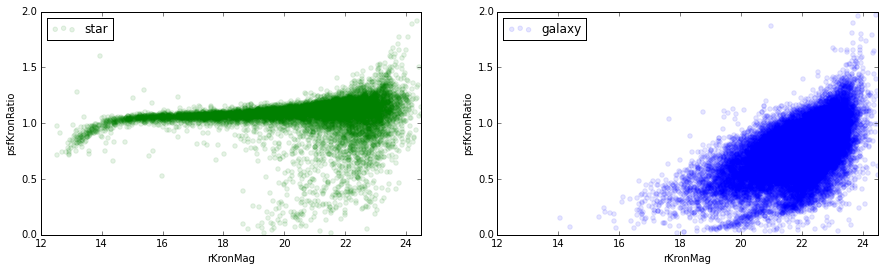

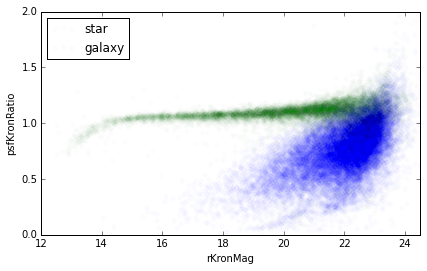

In [67]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
det_mask = (cat.mean_psfKronRatio > 0)&(cat.rKronMag > 0)
plt.scatter(cat.rKronMag[GT_star&det_mask], cat.mean_psfKronRatio[GT_star&det_mask],  
            color='green', alpha=0.1, label='star')
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0,2.0])
plt.subplot(1,2,2)
plt.scatter(cat.rKronMag[GT_galaxy&det_mask], cat.mean_psfKronRatio[GT_galaxy&det_mask],  
            color='blue', alpha=0.1, label='galaxy')
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0,2.0])
plt.show()

plt.figure(figsize=(6.8,4))
plt.scatter(cat.rKronMag[GT_star&det_mask], cat.mean_psfKronRatio[GT_star&det_mask],  
            color='green', alpha=0.01, label='star')
plt.scatter(cat.rKronMag[GT_galaxy&det_mask], cat.mean_psfKronRatio[GT_galaxy&det_mask],  
            color='blue', alpha=0.01, label='galaxy')
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0.,2.0])
plt.show()

# Using the $\chi$ value instead of the distance from the model line. 

model = f(x)

$\chi =$ [y - f(x)]/[$\sigma_y^2$ + ($\sigma_x$ df(x)/dx)$^2$]

Roughly coresponding to $\sigma$ for the normal distribution.
It allows us more statistically precise analysis.

In [68]:
def  calc_chi_from_thre(a, b, c, mag, mag_err, pKratio, pKratio_err): # model: y = a(x-b)**c 
    a, b, c = np.array(a), np.array(b), np.array(c)
    model = (a*(mag-b)**c).astype(float)
    model_diff = (a*c*(mag-b)**(c-1)).astype(float)
    chi = (pKratio - model)/np.sqrt(pKratio_err**2 + (model_diff*mag_err)**2)
    return np.array(chi)

In [69]:
GT = np.ones(len(cat))
GT[GT_galaxy] = 0

In [70]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Deciding the model based on ROC AUC value. 

In [71]:
def calc_acu_score(a_list, b_list, c_list, mag, mag_err, pKratio, pKratio_err, GT):
    true = GT
    ROC_AUC_list = []
    a_out = []
    b_out = []
    c_out = []
    for i in range(0,len(a_list)):
        for j in range(0,len(b_list)):
            for k in range(0,len(c_list)):
                chi = calc_chi_from_thre(a_list[i], b_list[j], c_list[k], mag, mag_err, pKratio, pKratio_err)
                ROC_AUC_list.append(roc_auc_score(true, chi))
                a_out.append(a_list[i])
                b_out.append(b_list[j])
                c_out.append(c_list[k])
    return a_out, b_out,c_out, ROC_AUC_list

In [72]:
def optim_acu_score(a, b, c, mag, mag_err, pKratio, pKratio_err, true):
    return -roc_auc_score(true, calc_chi_from_thre(a, b, c, mag, mag_err, pKratio, pKratio_err))

# Constant threshold

In [73]:
from scipy.optimize import *

In [74]:
def optim_acu_score(a, b, c, mag, mag_err, pKratio, pKratio_err, true):
    return -roc_auc_score(true, calc_chi_from_thre(a, b, c, mag, mag_err, pKratio, pKratio_err))
a = 0 
b = 0
c = 0
mag = cat.rKronMag[det_mask]
mag_err = cat.rKronMagErr[det_mask]
pKratio = cat.mean_psfKronRatio[det_mask]
pKratio_err = cat.mean_psfKronRatioerr[det_mask]
true = GT[det_mask]

roc_auc_score(true, calc_chi_from_thre(a, b, c, mag, mag_err, pKratio, pKratio_err))

0.76065084293810892

# Linear function

In [75]:
def optim_acu_score(a, b, c, mag, mag_err, pKratio, pKratio_err, true):
    return -roc_auc_score(true, calc_chi_from_thre(a, b, c, mag, mag_err, pKratio, pKratio_err))
b = 0
c = 1
mag = cat.rKronMag[det_mask]
mag_err = cat.rKronMagErr[det_mask]
pKratio = cat.mean_psfKronRatio[det_mask]
pKratio_err = cat.mean_psfKronRatioerr[det_mask]
true = GT[det_mask]

arg = (b, c, mag, mag_err, pKratio, pKratio_err, true, )
fmin(optim_acu_score, [0.05], args=arg)

Optimization terminated successfully.
         Current function value: -0.933452
         Iterations: 8
         Function evaluations: 16


array([ 0.04335938])

# Parabolic function

In [76]:
def optim_acu_score(a, c, mag, mag_err, pKratio, pKratio_err, true):
    return -roc_auc_score(true, calc_chi_from_thre(a[0], a[1], c, mag, mag_err, pKratio, pKratio_err))
c = 2
mag = cat.rKronMag[det_mask]
mag_err = cat.rKronMagErr[det_mask]
pKratio = cat.mean_psfKronRatio[det_mask]
pKratio_err = cat.mean_psfKronRatioerr[det_mask]
true = GT[det_mask]

arg = (c, mag, mag_err, pKratio, pKratio_err, true, )
fmin(optim_acu_score, np.array([0, 0]), args=arg)

Optimization terminated successfully.
         Current function value: -0.930588
         Iterations: 18
         Function evaluations: 34


array([ 0.00207352, -0.00234436])

# Exponential function

In [77]:
def  calc_chi_from_thre1(a, b, mag, mag_err, pKratio, pKratio_err): # model: y = a*exp(b*x)
    a, b = np.array(a), np.array(b)
    model = (a*np.exp(b*mag)).astype(float)
    model_diff = (a*b*np.exp(b*mag)).astype(float)
    chi = (pKratio - model)/np.sqrt(pKratio_err**2 + (model_diff*mag_err)**2)
    return np.array(chi)

def optim_acu_score(a, mag, mag_err, pKratio, pKratio_err, true):
    return -roc_auc_score(true, calc_chi_from_thre1(a[0], a[1], mag, mag_err, pKratio, pKratio_err))
mag = cat.rKronMag[det_mask]
mag_err = cat.rKronMagErr[det_mask]
pKratio = cat.mean_psfKronRatio[det_mask]
pKratio_err = cat.mean_psfKronRatioerr[det_mask]/cat.mean_psfKronRatio[det_mask]
true = GT[det_mask]

arg = (mag, mag_err, pKratio, pKratio_err, true, )
fmin(optim_acu_score, [-10,0], args=arg)


Optimization terminated successfully.
         Current function value: -0.934146
         Iterations: 74
         Function evaluations: 143


array([ 0.46612075,  0.03056158])

# Calculating the best intercept of the linear threshold model based on acuraccy.  

In [78]:
def optim_acu_score(b, a, c, mag, mag_err, pKratio, pKratio_err, true):
    chi = calc_chi_from_thre(a, b, c, mag, mag_err, pKratio, pKratio_err)
    pred = np.ones(len(chi))
    pred[chi < 0] = 0
    return -accuracy_score(true, pred)
a = 0.04335938
c = 1
mag = cat.rKronMag[det_mask]
mag_err = cat.rKronMagErr[det_mask]
pKratio = cat.mean_psfKronRatio[det_mask]
pKratio_err = cat.mean_psfKronRatioerr[det_mask]
true = GT[det_mask]

arg = (a, c, mag, mag_err, pKratio, pKratio_err, true, )
fmin(optim_acu_score, [-2], args=arg)

Optimization terminated successfully.
         Current function value: -0.901565
         Iterations: 12
         Function evaluations: 30


array([-2.16875])

In [79]:
def optim_acu_score (a, c, mag, mag_err, pKratio, pKratio_err, true):
    chi = calc_chi_from_thre(a[0], a[1], c, mag, mag_err, pKratio, pKratio_err)
    pred = np.ones(len(chi))
    pred[chi < 0] = 0
    return -accuracy_score(true, pred)
c = 1
mag = cat.rKronMag[det_mask]
mag_err = cat.rKronMagErr[det_mask]
pKratio = cat.mean_psfKronRatio[det_mask]
pKratio_err = cat.mean_psfKronRatioerr[det_mask]
true = GT[det_mask]

arg = (c, mag, mag_err, pKratio, pKratio_err, true, )
fmin(optim_acu_score, [0.06, -2], args=arg)

Optimization terminated successfully.
         Current function value: -0.901838
         Iterations: 27
         Function evaluations: 69


array([ 0.0436106 , -2.08449097])

# Plotting 

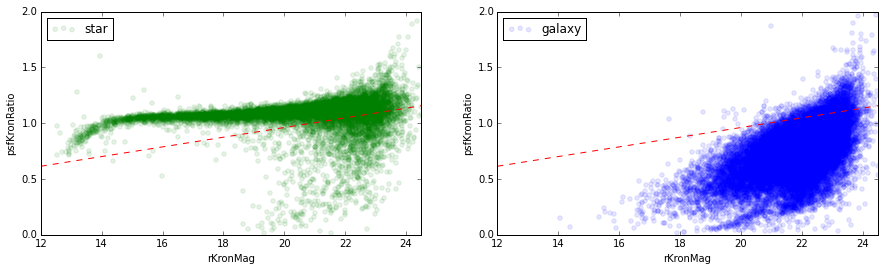

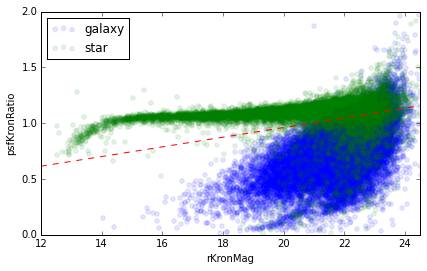

In [80]:
xp = np.arange(10, 30, 0.1)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
det_mask = (cat.mean_psfKronRatio > 0)&(cat.rKronMag > 0)
plt.scatter(cat.rKronMag[GT_star&det_mask], cat.mean_psfKronRatio[GT_star&det_mask],  
            color='green', alpha=0.1, label='star')
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0,2.0])
plt.subplot(1,2,2)
plt.scatter(cat.rKronMag[GT_galaxy&det_mask], cat.mean_psfKronRatio[GT_galaxy&det_mask],  
            color='blue', alpha=0.1, label='galaxy')
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0,2.0])
plt.show()

plt.figure(figsize=(6.8,4))
plt.scatter(cat.rKronMag[GT_galaxy&det_mask], cat.mean_psfKronRatio[GT_galaxy&det_mask],  
            color='blue', alpha=0.1, label='galaxy')
plt.scatter(cat.rKronMag[GT_star&det_mask], cat.mean_psfKronRatio[GT_star&det_mask],  
            color='green', alpha=0.1, label='star')
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0.,2.0])
plt.show()

In [81]:
chi = calc_chi_from_thre(0.04335938, -2.16875, 1, mag, mag_err, pKratio, pKratio_err)

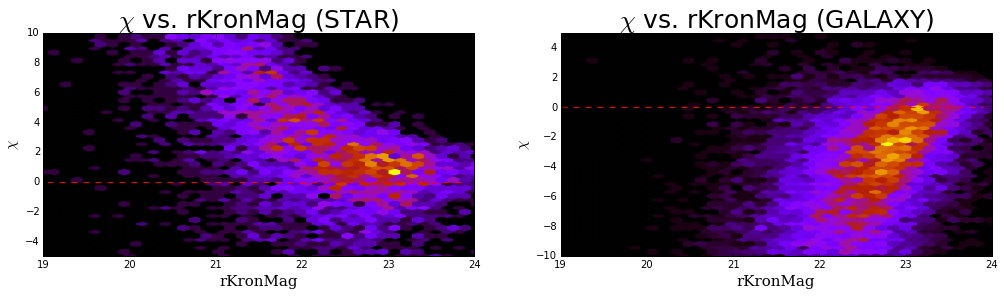

In [82]:
GT_star = cat.MU_CLASS[det_mask] == 2 
GT_galaxy = cat.MU_CLASS[det_mask] == 1
xp = np.arange(14, 24, 0.1)

star_range = (-5 < chi) & (chi <  10)
galaxy_range = (-10 < chi) & (chi <  5)

plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
plt.plot(xp, np.zeros(len(xp)),  '--', lw=1, color="red")
plt.hexbin(mag[GT_star&star_range], chi[GT_star&star_range], cmap="gnuplot", gridsize=50)
plt.title('$\chi$ vs. rKronMag (STAR)', fontsize=25)
plt.xlabel('rKronMag', fontname='serif', fontsize=15)
plt.ylabel('$\chi$', fontname='serif', fontsize=15)
plt.xlim(19,24)
plt.subplot(1,2,2)
plt.hexbin(mag[GT_galaxy&galaxy_range], chi[GT_galaxy&galaxy_range],  cmap="gnuplot", gridsize=50)
plt.plot(xp, np.zeros(len(xp)),  '--', lw=1, color="red")
plt.title('$\chi$ vs. rKronMag (GALAXY)', fontsize=25)
plt.xlabel('rKronMag', fontname='serif', fontsize=15)
plt.ylabel('$\chi$', fontname='serif', fontsize=15)
plt.xlim(19,24)
plt.show()


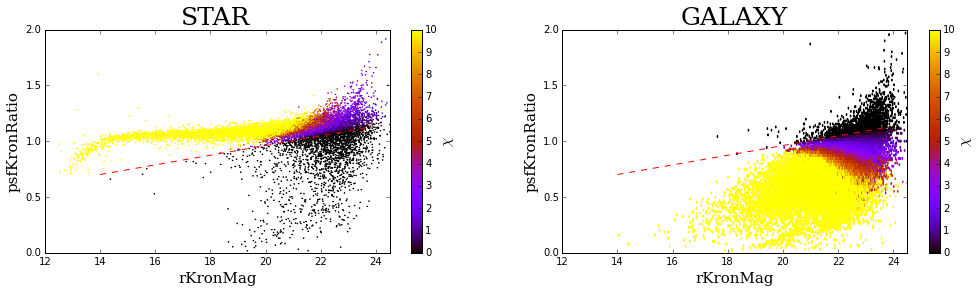

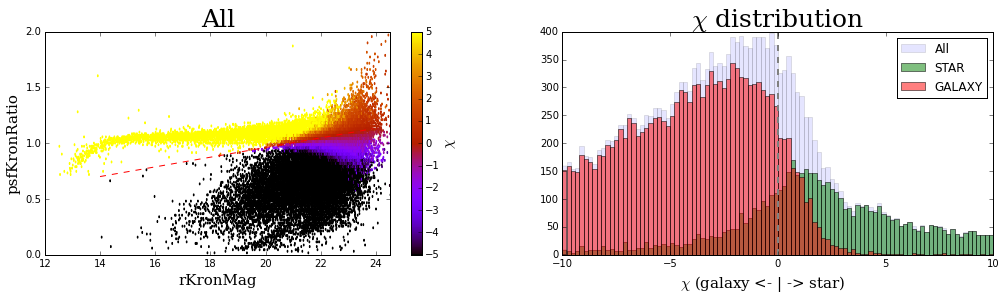

In [83]:
plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
plt.hexbin(mag[GT_star], pKratio[GT_star], chi[GT_star], 
           gridsize=500, vmin=0, vmax=10, cmap="gnuplot")
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.title('STAR', fontname='serif', fontsize=25)
plt.xlabel('rKronMag' , fontname='serif', fontsize=15)
plt.ylabel('psfKronRatio' , fontname='serif', fontsize=15)
plt.axis([12,24.5,0.,2.0])
cb = plt.colorbar()
cb.set_label('$\chi$', fontname='serif', fontsize=15)
plt.subplot(1,2,2)
plt.hexbin(mag[GT_galaxy], pKratio[GT_galaxy],  -chi[GT_galaxy], 
           gridsize=500, vmin=0, vmax=10, cmap="gnuplot")
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.title('GALAXY', fontname='serif', fontsize=25)
plt.xlabel('rKronMag' , fontname='serif', fontsize=15)
plt.ylabel('psfKronRatio' , fontname='serif', fontsize=15)
plt.axis([12,24.5,0.,2.0])
cb = plt.colorbar()
cb.set_label('$\chi$', fontname='serif', fontsize=15)
plt.show()

plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
plt.hexbin(mag, pKratio, chi, 
           gridsize=500, vmin=-5, vmax=5, cmap="gnuplot")
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.title('All', fontname='serif', fontsize=25)
plt.xlabel('rKronMag' , fontname='serif', fontsize=15)
plt.ylabel('psfKronRatio' , fontname='serif', fontsize=15)
plt.axis([12,24.5,0.,2.0])
cb = plt.colorbar()
cb.set_label('$\chi$', fontname='serif', fontsize=15)
plt.subplot(1,2,2)

plt.hist(chi, range=(-10, 10), bins=100, alpha=0.1, label='All')
plt.xlim(-10, 10)
plt.ylim(0,400)
plt.hist(chi[GT_star], range=(-10, 10), bins=100, alpha=0.5, label='STAR')
plt.xlim(-10, 10)
plt.ylim(0,400)
plt.hist(chi[GT_galaxy], range=(-10, 10), bins=100, alpha=0.5, label='GALAXY')
plt.xlim(-10, 10)
plt.ylim(0,400)
plt.plot([0,0], [0,500], '--', lw=2, color='grey')
plt.title('$\chi$ distribution', fontname='serif', fontsize=25)
plt.xlabel('$\chi$ (galaxy <- | -> star)       ', fontname='serif', fontsize=15)
plt.legend(loc='best')
plt.show()

In [166]:
hist_star = plt.hist( -chi[GT_star], bins=np.arange(-20,5000,1), cumulative=True, normed=True, )
hist_galaxy = plt.hist( chi[GT_galaxy], bins=np.arange(-5000,20,1), cumulative=True, normed=True, )
plt.close()

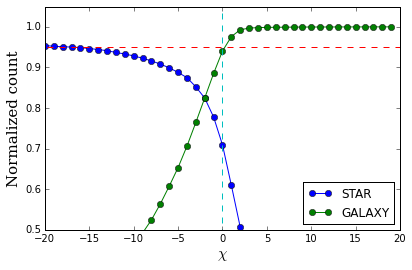

In [172]:
plt.plot(-hist_star[1][1:len(hist_star[1])], hist_star[0], 'o-', label='STAR')
plt.plot(hist_galaxy[1][1:len(hist_galaxy[1])], hist_galaxy[0], 'o-', label='GALAXY')
plt.plot([-50, 50], [0.95, 0.95], '--')
plt.plot([0, 0], [0, 2], '--')
plt.xlabel('$\chi$' , fontname='serif', fontsize=15)
plt.ylabel('Normalized count' , fontname='serif', fontsize=15)
plt.legend(loc='best')
plt.xlim(-20, 20)
plt.ylim(0.5, 1.05)
plt.show()
plt.close()

# Applying the model to SDSS x PS1 catalog

In [173]:
cat1 = pd.read_csv("SDSS_PS1_Stack_All_9_20_tachibana.csv")
cat2 = pd.read_csv("SDSS_PS1_Stack_All_20_24_tachibana.csv")

In [174]:
sdss_ps1 = pd.concat([cat1,cat2])

In [175]:
cat = sdss_ps1.drop_duplicates(['objID'])

In [176]:
filter_name =  ['g', 'r', 'i', 'z', 'y']
psfmag_name = 'PSFMag'
kronmag_name = 'KronMag'
psfmagerr_name = 'PSFMagErr'
kronmagerr_name = 'KronMagErr'
psfmag_list = []
kronmag_list = []
psfmagerr_list = []
kronmagerr_list = []
for fil in filter_name:
    psfmag_list.append(fil+psfmag_name)
    kronmag_list.append(fil+kronmag_name)
    psfmagerr_list.append(fil+psfmagerr_name)
    kronmagerr_list.append(fil+kronmagerr_name)
mag_list = psfmag_list + kronmag_list + psfmagerr_list + kronmagerr_list
PS_mag = cat[mag_list]
weight_norm = np.zeros(len(PS_mag))
det_num = np.zeros(len(PS_mag))
mean_flux_ratio_w =np.zeros(len(PS_mag))
mean_flux_ratioerr_w =np.zeros(len(PS_mag))

for fil in filter_name:
    psf_col_name = fil + psfmag_name
    kron_col_name = fil + kronmag_name
    psferr_col_name = fil + psfmagerr_name
    kronerr_col_name = fil + kronmagerr_name
    
    psf_det_flux = np.power(10, -0.4*(PS_mag[psf_col_name].values + 48.6),                                               
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[psf_col_name].values != -999)/1e-27
    
    kron_det_flux = np.power(10, -0.4*(PS_mag[kron_col_name].values + 48.6),
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[kron_col_name].values != -999)/1e-27

    psferr_det_flux = np.multiply(0.4*np.log(10), psf_det_flux*PS_mag[psferr_col_name],                                               
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[psf_col_name].values != -999)
    
    kronerr_det_flux = np.multiply(0.4*np.log(10), kron_det_flux*PS_mag[kronerr_col_name],
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[kron_col_name].values != -999)
    
    psf_det_NS = np.divide(psferr_det_flux, psf_det_flux,
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[psf_col_name].values != -999)
    
    kron_det_NS = np.divide(kronerr_det_flux, kron_det_flux,
                                              out = np.zeros_like(mean_flux_ratio_w),
                                              where = PS_mag[kron_col_name].values != -999)
    
    mask = (psf_det_flux!=0)&(kron_det_flux!=0)
    
    flux_ratio = np.divide(psf_det_flux, kron_det_flux, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    flux_ratio_err = np.multiply(flux_ratio, np.sqrt(psf_det_NS**2 +  kron_det_NS**2), 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
                                 
    weight = np.divide(1, flux_ratio_err**2, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    flux_ratio_w = np.multiply(flux_ratio, weight, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    flux_ratioerr_w = np.multiply(flux_ratio_err, weight, 
                                              out = np.zeros_like(mean_flux_ratio_w), 
                                              where = mask)
    
    mean_flux_ratio_w += flux_ratio_w
    mean_flux_ratioerr_w += flux_ratioerr_w
    weight_norm += weight
    det_num += mask.astype(int)
    
mask = (mean_flux_ratio_w != 0)&(weight_norm != 0)
mean_flux_ratio = np.divide(mean_flux_ratio_w, weight_norm, 
                         out = np.zeros_like(mean_flux_ratio_w), 
                         where = mask)
mean_flux_ratioerr = np.divide(mean_flux_ratioerr_w, weight_norm*np.sqrt(det_num), 
                         out = np.zeros_like(mean_flux_ratio_w), 
                         where = mask)
ratio_kwargs = {'mean_psfKronRatio' : mean_flux_ratio}
ratioerr_kwargs = {'mean_psfKronRatioerr' : mean_flux_ratioerr}

cat = cat.assign(**ratio_kwargs)
cat = cat.assign(**ratioerr_kwargs)

In [177]:
GT_star = (cat['class']=='STAR') | (cat['class']=='QSO')
GT_galaxy = cat['class']=='GALAXY'

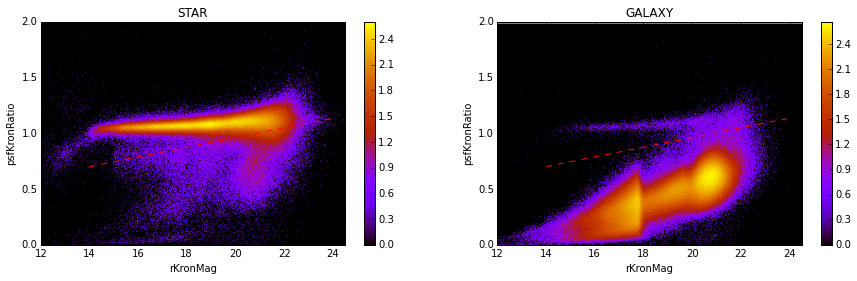

In [178]:
xp = np.arange(14, 24, 0.1)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
det_mask = (cat.mean_psfKronRatio > 0)&(cat.rKronMag > 0)&(cat.mean_psfKronRatio < 2)
plt.hexbin(cat.rKronMag[GT_star&det_mask], cat.mean_psfKronRatio[GT_star&det_mask],  
            cmap='gnuplot', bins='log', gridsize=500)
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.colorbar()
plt.title('STAR')
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0,2.0])
plt.subplot(1,2,2)
plt.hexbin(cat.rKronMag[GT_galaxy&det_mask], cat.mean_psfKronRatio[GT_galaxy&det_mask],  
            cmap='gnuplot', bins='log', gridsize=500)
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.colorbar()
plt.title('GALAXY')
plt.ylabel('psfKronRatio')
plt.xlabel('rKronMag')
plt.legend(loc='upper left')
plt.axis([12,24.5,0,2.0])
plt.show()

In [179]:
GT = np.ones(len(cat))
GT[GT_galaxy] = 0
mag = cat.rKronMag[det_mask]
mag_err = cat.rKronMagErr[det_mask]
pKratio = cat.mean_psfKronRatio[det_mask]
pKratio_err = cat.mean_psfKronRatioerr[det_mask]/cat.mean_psfKronRatio[det_mask]
true = GT[det_mask]

chi = calc_chi_from_thre(0.04335938, -2.16875, 1, mag, mag_err, pKratio, pKratio_err)

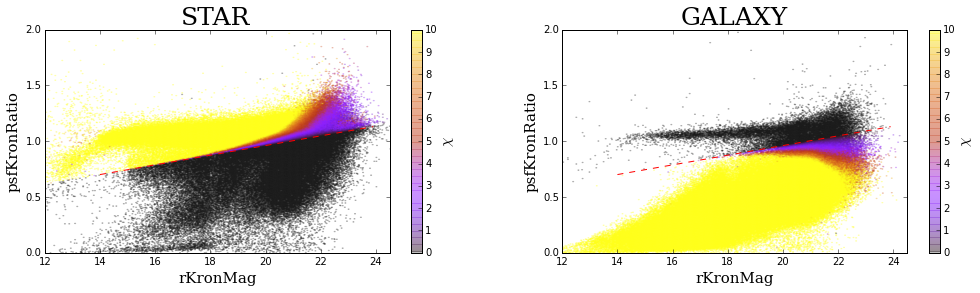

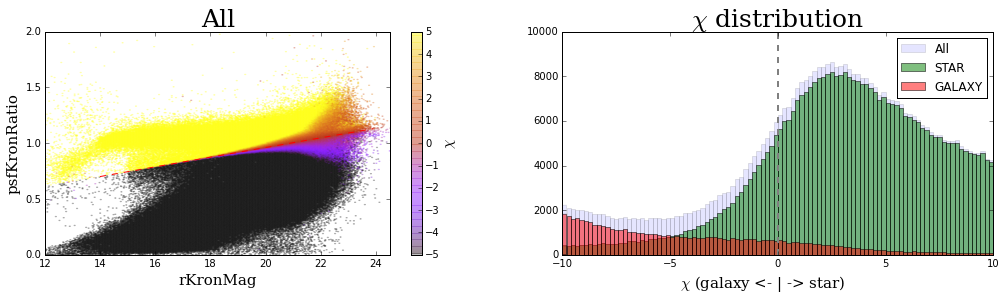

In [180]:
GT_star = (cat['class'][det_mask]=='STAR') | (cat['class'][det_mask]=='QSO')
GT_galaxy = cat['class'][det_mask]=='GALAXY'

plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
plt.hexbin(mag[GT_star], pKratio[GT_star], chi[GT_star], 
           gridsize=500, vmin=0, vmax=10, cmap="gnuplot", alpha=0.25)
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.title('STAR', fontname='serif', fontsize=25)
plt.xlabel('rKronMag' , fontname='serif', fontsize=15)
plt.ylabel('psfKronRatio' , fontname='serif', fontsize=15)
plt.axis([12,24.5,0.,2.0])
cb = plt.colorbar()
cb.set_label('$\chi$', fontname='serif', fontsize=15)
plt.subplot(1,2,2)
plt.hexbin(mag[GT_galaxy], pKratio[GT_galaxy],  -chi[GT_galaxy], 
           gridsize=500, vmin=0, vmax=10, cmap="gnuplot", alpha=0.25)
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.title('GALAXY', fontname='serif', fontsize=25)
plt.xlabel('rKronMag' , fontname='serif', fontsize=15)
plt.ylabel('psfKronRatio' , fontname='serif', fontsize=15)
plt.axis([12,24.5,0.,2.0])
cb = plt.colorbar()
cb.set_label('$\chi$', fontname='serif', fontsize=15)
plt.show()

plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
plt.hexbin(mag, pKratio, chi, 
           gridsize=500, vmin=-5, vmax=5, cmap="gnuplot", alpha=0.25)
plt.plot(xp, (xp+2.16875)*0.04335938,  '--', lw=1, color="red")
plt.title('All', fontname='serif', fontsize=25)
plt.xlabel('rKronMag' , fontname='serif', fontsize=15)
plt.ylabel('psfKronRatio' , fontname='serif', fontsize=15)
plt.axis([12,24.5,0.,2.0])
cb = plt.colorbar()
cb.set_label('$\chi$', fontname='serif', fontsize=15)
plt.subplot(1,2,2)

plt.hist(chi, range=(-10, 10), bins=100, alpha=0.1, label='All')
plt.xlim(-10, 10)
plt.ylim(0,10000)
plt.hist(chi[GT_star], range=(-10, 10), bins=100, alpha=0.5, label='STAR')
plt.xlim(-10, 10)
plt.ylim(0,10000)
plt.hist(chi[GT_galaxy], range=(-10, 10), bins=100, alpha=0.5, label='GALAXY')
plt.xlim(-10, 10)
plt.ylim(0,10000)
plt.plot([0,0], [0,50000], '--', lw=2, color='grey')
plt.title('$\chi$ distribution', fontname='serif', fontsize=25)
plt.xlabel('$\chi$ (galaxy <- | -> star)       ', fontname='serif', fontsize=15)
plt.legend(loc='best')
plt.show()

In [181]:
pred = np.ones(len(true))
pred[chi<0]=0

print roc_auc_score(true,chi), accuracy_score(true, pred)

0.976736534871 0.952658066473


In [182]:
hist_star = plt.hist( -chi[GT_star], bins=np.arange(-20,5000,1), cumulative=True, normed=True, )
hist_galaxy = plt.hist( chi[GT_galaxy], bins=np.arange(-5000,20,1), cumulative=True, normed=True, )
plt.close()

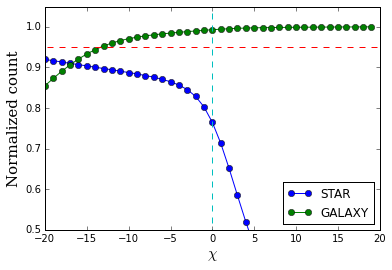

In [183]:
plt.plot(-hist_star[1][1:len(hist_star[1])], hist_star[0], 'o-', label='STAR')
plt.plot(hist_galaxy[1][1:len(hist_galaxy[1])], hist_galaxy[0], 'o-', label='GALAXY')
plt.plot([-50, 50], [0.95, 0.95], '--')
plt.plot([0, 0], [0, 2], '--')
plt.xlabel('$\chi$' , fontname='serif', fontsize=15)
plt.ylabel('Normalized count' , fontname='serif', fontsize=15)
plt.legend(loc='best')
plt.xlim(-20, 20)
plt.ylim(0.5, 1.05)
plt.show()
plt.close()